In [1]:
import string, re, json, pickle, warnings, nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
# importing the wordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bidi.algorithm import get_display
import arabic_reshaper
from data_preparation import take_a_shower, clean_content_aravec

%matplotlib inline
warnings.filterwarnings('ignore')

## Import data

In [84]:
df = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-8")
data = df[['Comment', 'is_off']]
data.head()

,Comment,is_off
0,برتوش ههههههه علام,1.0
1,معرفتش اعلاش حسيتها كتكدب,0.0
2,شوفوا يا برجوازيين البلاد ل كيهربوا لفلوس لدو...,0.0
3,ليش ما يعطوهم سفري .,0.0
4,ساقاطع هذا الموقع الذي هدفه نشر الكراهية تجاه ...,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  16000 non-null  object 
 1   is_off   15999 non-null  float64
dtypes: float64(1), object(1)
memory usage: 250.1+ KB


<Figure size 576x432 with 0 Axes>

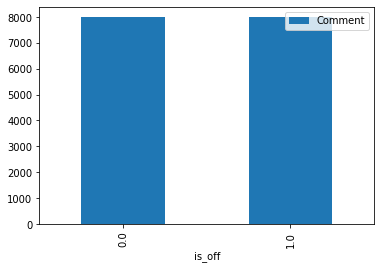

In [4]:
fig = plt.figure(figsize=(8,6))
data.groupby('is_off').count().plot.bar(ylim=0)
plt.show()

In [5]:
len(data.loc[data['is_off'] == 1.0])

7999

In [6]:
len(data.loc[data['is_off'] == 0.0])

8000

## Clean data

In [85]:
data.Comment = data.Comment.apply(take_a_shower)

In [27]:
data.shape

(16000, 2)

In [69]:
np.any(np.isnan(data.is_off))

True

In [70]:
data.dropna(inplace=True)

In [97]:
np.any(np.isnan(data.is_off))

True

In [96]:
np.where(np.isnan(data.is_off))

(array([4380]),)

In [105]:
data.iloc[4380]

Comment    حووا احراز فضيله
is_off                  NaN
Name: 4380, dtype: object

## Text Analyics & Visualization

In [28]:
comments = ' '.join(list(data.Comment))
comments[0:100]

'برتوش هه علام معرفتش اعلاش حسيتها كتكدب شوفوا برجوازيين البلاد كيهربوا لفلوس لدول الاجنبيه ديرو مشار'

In [29]:
words = comments.split(' ')

In [30]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:12]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:12]

In [31]:
bigrams_series

(الله, يعطيك)          281
(الله, ونعم)           166
(الدوله, الاسلاميه)    165
(ونعم, الوكيل)         165
(شوف, تيفي)            144
(شاء, الله)            134
(حسبي, الله)           107
(العلي, العظيم)         99
(بالله, العلي)          95
(الله, اكبر)            86
(الله, ينعل)            81
(حسبنا, الله)           79
dtype: int64

Text(0.5, 0, '# of Occurances')

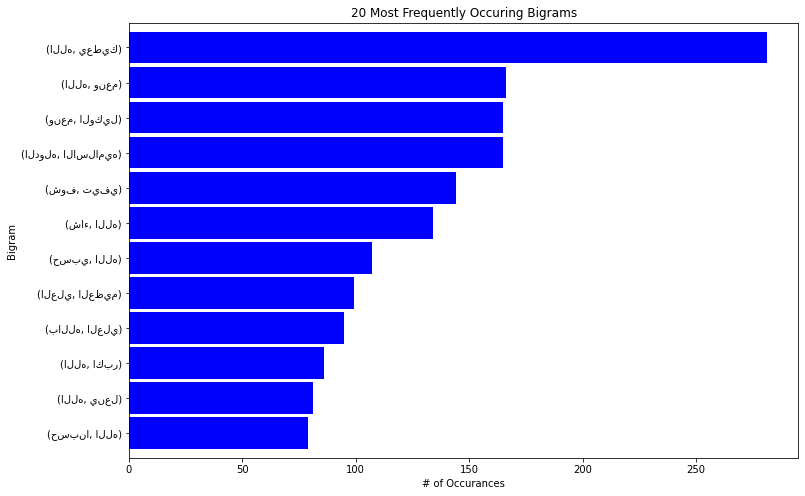

In [32]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

## Word Cloud

In [38]:
len(comments)

1194470

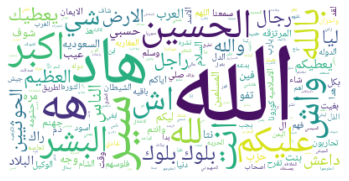

In [54]:
# handling arabic text
comments = arabic_reshaper.reshape(comments)
comments = get_display(comments)

wordcloud = WordCloud(font_path='assets/NotoNaskhArabic-Regular.ttf',
                      background_color="white",
#                       max_words=1000,
                      mode='RGBA').generate(comments)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
offensive_data = data.loc[data['is_off'] == 1.0]
print(len(offensive_data))
offensive_text = ' '.join(list(offensive_data.Comment))
print(offensive_text[0:100])
offensive_words = comments.split(' ')
print(len(offensive_words))

7999
برتوش هه علام ليتهم يسلمون منك ياذميم قطر ذميم العرب حسبي الله لماذا تحقدون فرنسا تشجعون الارهاب تعل
1692


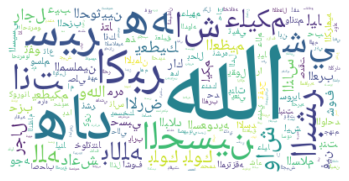

In [63]:
# handling arabic text
offensive_text = arabic_reshaper.reshape(offensive_text)
offensive_text = get_display(comments)

wordcloud = WordCloud(font_path='assets/NotoNaskhArabic-Regular.ttf',
                      background_color="white",
#                       max_words=1000,
                      mode='RGBA').generate(offensive_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## splitting the data into target and feature

In [86]:
feature = data.Comment
target = data.is_off
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

In [65]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(data['Comment'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [66]:
print(Train_X_Tfidf.shape)
print(Test_X_Tfidf.shape)

(12800, 56956)
(3200, 56956)


## Logistic Regression Model

In [87]:
# make pipeline
pipe = make_pipeline(TfidfVectorizer(),
                    LogisticRegression())
# make param grid
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(pipe, param_grid, cv=5)
model.fit(X_train,Y_train)

# make prediction and print accuracy
prediction = model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [80]:
model.best_params_

{'logisticregression__C': 10}

In [81]:
model.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1.])

In [82]:
model.predict([take_a_shower('زي الهوا يا حبيبي زي الهوا')])

array([0.])

In [24]:
pickle.dump(model, open('./models/tfidf/lr_model.model', 'wb'))

## SVM Model

In [83]:
pipe = make_pipeline(TfidfVectorizer(),
                     SVC())
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly'],
             'svc__gamma': [0.1, 1, 10, 100],
             'svc__C': [0.1, 1, 10, 100]}

svc_model = GridSearchCV(pipe, param_grid)
svc_model.fit(X_train, Y_train)

prediction = svc_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.78
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78      1618
         1.0       0.79      0.75      0.77      1582

    accuracy                           0.78      3200
   macro avg       0.78      0.78      0.78      3200
weighted avg       0.78      0.78      0.78      3200



In [26]:
svc_model.best_params_

{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}

In [27]:
svc_model.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1])

In [27]:
pickle.dump(svc_model, open('./models/tfidf/svm_model.pkl', 'wb'))

## Random Forest Model

In [28]:
pipe = make_pipeline(TfidfVectorizer(),
                    RandomForestClassifier())

param_grid = {'randomforestclassifier__n_estimators':[10, 100, 1000],
             'randomforestclassifier__max_features':['sqrt', 'log2']}

rf_model = GridSearchCV(pipe, param_grid, cv=5)
rf_model.fit(X_train,Y_train)

prediction = rf_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")

Accuracy score is 0.80


In [30]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1406
           1       0.83      0.76      0.79      1394

    accuracy                           0.80      2800
   macro avg       0.81      0.80      0.80      2800
weighted avg       0.81      0.80      0.80      2800



In [34]:
rf_model.best_params_

{'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__n_estimators': 100}

In [36]:
rf_model.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1])

In [41]:
pickle.dump(rf_model, open('./models/tfidf/randomforest_model.model', 'wb'))

## Naive Bayes Model

In [42]:
pipe = make_pipeline(TfidfVectorizer(),
                    MultinomialNB())
pipe.fit(X_train,Y_train)
prediction = pipe.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.72
              precision    recall  f1-score   support

           0       0.84      0.55      0.66      1406
           1       0.66      0.89      0.76      1394

    accuracy                           0.72      2800
   macro avg       0.75      0.72      0.71      2800
weighted avg       0.75      0.72      0.71      2800



In [44]:
pipe.predict([take_a_shower('الزمر فالطوندونس هو باطمة تلاقيتو تواتيتو')])

array([1])

In [45]:
pickle.dump(pipe, open('./models/tfidf/naive_bayes_model.model', 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)